In [1]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import sys
sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

from owslib.ogcapi.features import Features
import geopandas as gpd
import datetime as dt
from datetime import datetime, timedelta

In [16]:
neon = gpd.read_file("https://agriculture.canada.ca/atlas/data_donnees/nationalEcologicalFramework/data_donnees/geoJSON/ez/nef_ca_ter_ecozone_v2_2.geojson")
neon.columns
neon["DomainID"] = neon['ECOZONE_ID']


# tmp = gpd.read_file("/projects/old_shared/fire_weather_vis/ref_data/Canadian_prov/georef-canada-province@public.geojson")
# tmp_names = gpd.read_file("/projects/old_shared/fire_weather_vis/ref_data/Canadian_prov/georef-canada-province@public.csv")

# #neon.DomainID
# tmp_names = tmp_names[['Official Name Province / Territory (English)', 'Official Name Province / Territory (French)']]
# tmp_names = tmp_names.rename(columns={'Official Name Province / Territory (English)':"prov_name_en", 
#                                      'Official Name Province / Territory (French)': 'prov_name_fr' })

# tmp = tmp.merge(tmp_names, on = "prov_name_fr")
# tmp = tmp[['prov_name_fr', 'prov_name_en', 'geometry']]
# tmp

,geo_point_2d,year,prov_area_code,prov_type,prov_name_fr,geometry,prov_name_en
0,"{'lon': -114.51101438986483, 'lat': 55.1689029...",2021,CAN,province,Alberta,"POLYGON ((-110.00502 48.99970, -110.00449 49.5...",Alberta
1,"{'lon': -135.51007960983821, 'lat': 63.6304438...",2021,CAN,territory / territoire,Yukon,"MULTIPOLYGON (((-139.13388 69.63737, -139.2478...",Yukon
2,"{'lon': -97.43375328505664, 'lat': 54.93018410...",2021,CAN,province,Manitoba,"POLYGON ((-94.82808 60.00000, -95.32500 60.000...",Manitoba
3,"{'lon': -60.51575069823122, 'lat': 52.88843621...",2021,CAN,province,Terre-Neuve-et-Labrador,"MULTIPOLYGON (((-53.63678 48.87151, -53.67894 ...",Newfoundland and Labrador
4,"{'lon': -66.37667726184117, 'lat': 46.61898879...",2021,CAN,province,Nouveau-Brunswick,"MULTIPOLYGON (((-66.93908 45.02470, -67.01600 ...",New Brunswick
5,"{'lon': -118.98262958354398, 'lat': 66.3689231...",2021,CAN,territory / territoire,Territoires du Nord-Ouest,"MULTIPOLYGON (((-109.83296 75.93393, -110.0324...",Northwest Territories
6,"{'lon': -63.24228135586117, 'lat': 46.38954858...",2021,CAN,province,Île-du-Prince-Édouard,"POLYGON ((-61.98606 46.46286, -62.14666 46.484...",Prince Edward Island
7,"{'lon': -105.89075902236681, 'lat': 54.4167141...",2021,CAN,province,Saskatchewan,"POLYGON ((-102.00000 60.00000, -102.75000 60.0...",Saskatchewan
8,"{'lon': -63.32450309629852, 'lat': 45.15131558...",2021,CAN,province,Nouvelle-Écosse,"MULTIPOLYGON (((-65.60612 43.51377, -65.65127 ...",Nova Scotia
9,"{'lon': -86.0409603890758, 'lat': 50.452667579...",2021,CAN,province,Ontario,"MULTIPOLYGON (((-79.91454 44.99301, -79.91794 ...",Ontario


In [15]:
tmp_names

,Geo Point,Geo Shape,Year,Official Code Province / Territory,Official Name Province / Territory (English),Iso 3166-3 Area Code,Type (English / French),Official Name Province / Territory (French),geometry
0,"54.93018410368252, -97.43375328505664","{""coordinates"": [[[-94.82807905269526, 60.0000...",2021,46,Manitoba,CAN,province,Manitoba,None
1,"66.36892317260285, -118.98262958354398","{""coordinates"": [[[[-109.83296228999279, 75.93...",2021,61,Northwest Territories,CAN,territory / territoire,Territoires du Nord-Ouest,None
2,"46.3895485809831, -63.24228135586117","{""coordinates"": [[[-61.98606088698219, 46.4628...",2021,11,Prince Edward Island,CAN,province,Île-du-Prince-Édouard,None
3,"45.15131558491417, -63.32450309629852","{""coordinates"": [[[[-65.60611848286614, 43.513...",2021,12,Nova Scotia,CAN,province,Nouvelle-Écosse,None
4,"54.755183090076166, -124.7656381299199","{""coordinates"": [[[[-124.68934793412477, 49.54...",2021,59,British Columbia,CAN,province,Colombie-Britannique,None
5,"53.395283499640165, -71.78624104931967","{""coordinates"": [[[[-73.8640722106924, 45.5185...",2021,24,Quebec,CAN,province,Québec,None
6,"71.04138944482501, -88.8416338799438","{""coordinates"": [[[[-106.67059436693235, 73.67...",2021,62,Nunavut,CAN,territory / territoire,Nunavut,None
7,"55.16890299842028, -114.51101438986483","{""coordinates"": [[[-110.00502263037129, 48.999...",2021,48,Alberta,CAN,province,Alberta,None
8,"54.416714191425804, -105.89075902236681","{""coordinates"": [[[-102.00000001273865, 59.999...",2021,47,Saskatchewan,CAN,province,Saskatchewan,None
9,"50.45266757986579, -86.0409603890758","{""coordinates"": [[[[-79.91453785770378, 44.993...",2021,35,Ontario,CAN,province,Ontario,None


In [3]:
## Double check that we even are reading in the right number of large fires

snap = fv.prep_gdf(date = '20230803PM',handle_multi=False,only_lf=False,area_lim=5, path_region = "QuebecGlobalNRT_3571", year = "2023")
#snap[snap.index == 2010].explore()
print(snap.index)
snap.explore()


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


Int64Index([2012, 1933, 1953, 1888, 1936, 1966, 1870, 1850, 1954, 1836,
            ...
            1462, 1838, 1813, 1837, 1896,  952, 1895, 1894, 1967, 1932],
           dtype='int64', name='fireID', length=171)


In [5]:
#snap.index.

SyntaxError: invalid syntax (3490246635.py, line 1)

In [4]:
### Get all IDs

flist = os.listdir("/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/") 


import re

file_ids = [re.sub("([^a-zA-Z0-9].*)$", "", x) for x in flist]
file_ids = [re.sub("F", "", x) for x in file_ids]

ids = file_ids
file_ids = set(file_ids)

In [149]:
#s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/")

['veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI',
 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/ManualStationList.ISD-GHCN.StnMap.png',
 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/ManualStationList.fwiStnList.minHourlyCompleteness.10.ISDGHCNMaxPrecDiff.NaN.1990.2023.csv',
 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/ManualStationList.goodStnList.minYears.NaN.minMonthlyCount.NaN.includePrecipInGoodTotals.0.1990.2023.csv',
 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/ProcessRawYearlyISHDataFilesFromStationList_TransferToDiscover.m',
 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/README.DailyHourlyFWI.Global.txt',
 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/Wx',
 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/isd-history.csv']

In [5]:
#i = list(file_ids)[0]

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map, 
                      path_s3 = 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/', 
                      inter_type = '.linear.HourlyFWIFromHourlyInterpContinuous.csv')
st_dict = stations[['Lat', 'Lon']].to_dict('records')


#i = '11446'
i = '119'

year = "2023"

region = "QuebecGlobalNRT_3571"


# raw_fire = fv.load_large_fire(i, year = year, path_region= region)
# raw_fire["fireID"] = str(i)
# if (len(raw_fire) == 0):
#     print("NONEE")
# full = fv.get_gpm_spread(raw_fire)
# #print(full)
# ## Chop off at area asymptote. 5 consectutive days where area hasn't moved. 
# asymptote = full[full.farea_diff.rolling(5).sum() == 0].t
# if(not asymptote.empty):
#     print("entering if statement")
#     full = full[full.t < min(asymptote)]


st = stations.loc[(stations.Lat == sts.Lat[0]) & (stations.Lon == sts.Lon[0])]
dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/


NameError: name 'sts' is not defined

In [158]:
#stations

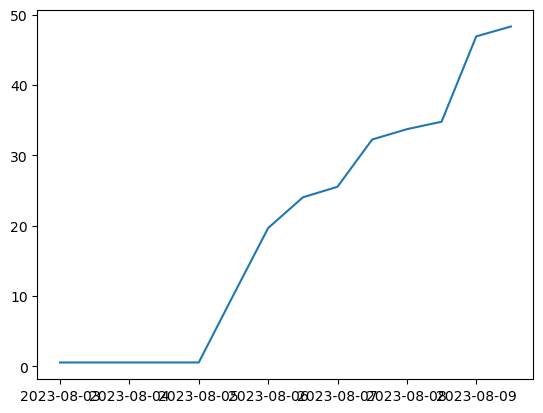

In [151]:
    
plt.plot(full.t, full.farea)

In [49]:
def station_spread(st_id_map, st_dict, files, i, year, region):

    try:
        raw_fire = fv.load_large_fire(i, year = year, path_region= region)
        raw_fire["fireID"] = str(i)
        if (len(raw_fire) == 0):
            print("Returning none")
            return(None)
        full = fv.get_gpm_spread(raw_fire)
        #print(full)
        ## Chop off at area asymptote. 5 consectutive days where area hasn't moved. 
        asymptote = full[full.farea_diff.rolling(5).sum() == 0].t
        if(not asymptote.empty):
            full = full[full.t < min(asymptote)]
    except Exception as e:
        print(e)
        print("Error at imerge_merge with Fire: ",i,)
        return(None)
#         bad_log = traceback.format_exc(limit = 40) # Get log of error
#         print(bad_log)
#         bad_ids.append(
#         {
#             "fireID": i, 
#             "func_failed": "imerge_merge",
#             "log": bad_log
#         }
#         )

    ### Find the closest station

    foi = full
    foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
    foi = foi.iloc[0] # First element

    stations = fv.st_avail(files, st_id_map = st_id_map, 
                      path_s3 = 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/', 
                      inter_type = '.linear.HourlyFWIFromHourlyInterpContinuous.csv')
    print(stations.columns)
    #stations = fv.closest_srch(st_dict, foi)
    all_st_search = fv.all_stations_search(st_dict = st_dict, fire_center = foi, id_key = st_id_map)
    print("final perimeter step")
    
    final_perimeter = full[full.t == max(full.t)]
    #print(final_perimeter.envelope.exterior.coords.xy)
    #lons = final_perimeter.envelope.exterior.coords.xy[0]
    #lats = final_perimeter.envelope.exterior.coords.xy[1]


    ### Find the neon region the fire is in. 

    regions = gpd.overlay(neon, final_perimeter, how = "intersection")
    regions = neon[neon.DomainID.isin(regions.DomainID)]
    #print(regions)

    ## get subset of stations that are close to the fire

    sub_search = all_st_search[all_st_search.Dist_to_fire < 1000]
    sub_search = gpd.GeoDataFrame(sub_search, geometry=gpd.points_from_xy(sub_search.Lon, sub_search.Lat))

    if(len(sub_search) > 0):
        ## Check if in any of the intersecting regions
        sts = gpd.overlay(sub_search.set_crs("epsg:4326"), regions.to_crs("epsg:4326"), how = 'intersection')
        
        if(sts.empty):
            print('No stations with ecoregion and distance radius')
            return(None)

        fire_min = min(full.t)
        fire_max = max(full.t)

        ### Check if overlapping time range
        sts.BEGIN = pd.to_datetime(sts['BEGIN'], format='%Y%m%d')
        sts.END = pd.to_datetime(sts['END'], format='%Y%m%d')
        tmp_sts = sts
        
        sts = sts[sts.END >= fire_max]
        sts = sts[sts.BEGIN <= fire_min]
        
        if(sts.empty):
            print('STAION START: ' + str(tmp_sts.BEGIN))
            print('STAION END: ' + str(tmp_sts.END))
            
            print('Fire START: ' + str(fire_min))
            print('Fire END: ' + str(fire_max))
            
            print('No stations with overlapping temporal range')
            return(None)



        if(len(sts) > 0):
            ## Optionally merge
            sts = sts[sts.Dist_to_fire == min(sts.Dist_to_fire)] ## Get closest station
            #st = fv.get_st(lat = sts.Lat, lon = sts.Lon, stations = stations)
            st = stations.loc[(stations.Lat == sts.Lat[0]) & (stations.Lon == sts.Lon[0])]
            #print(st.File_path.iloc[0])
            st = st[ ~st.File_path.str.contains("._")]
            
            dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
            dat = fv.date_convert(dat)
            full['st_ID'] = str(sts.USAF[0]) + "_" + str(sts.WBAN[0])
            full['st_dist_to_fire'] = str(sts.Dist_to_fire.unique())

            full_m = fv.fr_st_merge(full, dat,  sub_type = "month_before")
            #full_m = fv.fr_st_merge(full, dat)
            full_m["fireID"] = str(full_m.fireID[0])
            return(full_m)
    else:
        print("sub search was 0")

        ## Optionally write out a cheat-sheet
        
        
# def station_spread2(st_id_map, st_dict, files, i, year, region):


#     full = fv.load_large_fire(i, year = year, path_region= region)
#     full["fireID"] = str(i)


#     ### Find the closest station

#     foi = full
#     foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
#     foi = foi.iloc[0] # First element

#     stations = fv.st_avail(files, st_id_map = st_id_map)
#     #stations = fv.closest_srch(st_dict, foi)
#     all_st_search = fv.all_stations_search(st_dict = st_dict, fire_center = foi, id_key = st_id_map)

#     final_perimeter = full[full.t == max(full.t)]
#     #print(final_perimeter.envelope.exterior.coords.xy)
#     #lons = final_perimeter.envelope.exterior.coords.xy[0]
#     #lats = final_perimeter.envelope.exterior.coords.xy[1]


#     ### Find the neon region the fire is in. 

#     regions = gpd.overlay(neon, final_perimeter, how = "intersection")
#     regions = neon[neon.DomainID.isin(regions.DomainID)]
#     #print(regions)

#     ## get subset of stations that are close to the fire

#     sub_search = all_st_search[all_st_search.Dist_to_fire < 150]
#     sub_search = gpd.GeoDataFrame(sub_search, geometry=gpd.points_from_xy(sub_search.Lon, sub_search.Lat))

#     if(len(sub_search) > 0):
#         ## Check if in any of the intersecting regions
#         sts = gpd.overlay(sub_search.set_crs("epsg:4326"), regions.to_crs("epsg:4326"), how = 'intersection')
#         fire_min = min(full.t)
#         fire_max = max(full.t)

#         ### Check if overlapping time range
#         sts.BEGIN = pd.to_datetime(sts['BEGIN'], format='%Y%m%d')
#         sts.END = pd.to_datetime(sts['END'], format='%Y%m%d')

#         sts = sts[sts.END >= fire_max]
#         sts = sts[sts.BEGIN <= fire_min]
#         #print(sts)
#         if(len(sts) > 0):
#             ## Optionally merge
#             sts = sts[sts.Dist_to_fire == min(sts.Dist_to_fire)] ## Get closest station
#             #st = fv.get_st(lat = sts.Lat, lon = sts.Lon, stations = stations)
#             print(sts)
#             st = stations.loc[(stations.Lat == sts.Lat[0]) & (stations.Lon == sts.Lon[0])]
#             dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
#             dat = fv.date_convert(dat)
#             full['st_ID'] = str(sts.USAF[0]) + "_" + str(sts.WBAN[0])
#             full['st_dist_to_fire'] = str(sts.Dist_to_fire.unique())
#             full_m = fv.fr_st_merge(full, dat,  sub_type = "month_before")
#             full_m["fireID"] = str(full_m.fireID[0])
    
#             total = fv.get_gpm_spread(full_m)
#             return(total)

#         ## Optionally write out a cheat-sheet

In [50]:
def get_spread_period(full_fr, time_of_interest = 12,  hours_before = 0, lags = [-2,-4,-12,-24,-48]):
    
    lables = ["Night", "Day"]
    for i in lables:
        
        times_ig = full_fr["t"].loc[full_fr["spread_line" + i] == 2]
        times = full_fr["t"].loc[full_fr["spread_line" + i] == True] ## Is this acurate given the definitions above? 
        times_not = full_fr["t"].loc[full_fr["spread_line" + i] == False]
        #times_not = times_not[(times_not.dt.hour == 13) & (times_not.dt.minute == 30)]

        full_fr["spread_period"+ i] = np.nan
        full_fr["spread_period"+ i + "_igs"] = np.nan
    
        
        for t in times_ig:
            times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
            times_end = t - np.timedelta64((hours_before), "h")
            full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS

        for t in times:
            times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
            times_end = t - np.timedelta64((hours_before), "h")
            full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True


        for l in times_not:
            times_start = l - np.timedelta64((time_of_interest + hours_before), "h")
            times_end = l - np.timedelta64((hours_before), "h")
            full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = False

        for lag in lags:
            full_fr["spread_period"+ i +"_lag_" + str(lag)] = full_fr["spread_period"+ i].shift(lag)

    return(full_fr)

In [40]:

# i = '119'

# year = "2023"

# region = "QuebecGlobalNRT_3571"


# full = station_spread(st_id_map = st_id_map, st_dict = st_dict, files = files, i = i, year = year, region = region)
# full = get_spread_period(full)

#full

(array([19571.5, 19572. , 19572.5, 19573. , 19573.5, 19574. , 19574.5]),
 [Text(19571.5, 0, '08-02 12'),
  Text(19572.0, 0, '08-03 00'),
  Text(19572.5, 0, '08-03 12'),
  Text(19573.0, 0, '08-04 00'),
  Text(19573.5, 0, '08-04 12'),
  Text(19574.0, 0, '08-05 00'),
  Text(19574.5, 0, '08-05 12')])

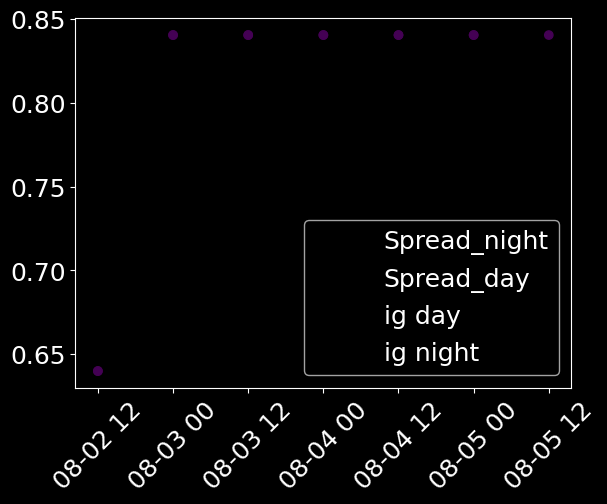

In [47]:
full

full = full.sort_values(by = ["t"])

plt.scatter(full.t.astype('datetime64[ns]'), full.farea, c = full["spread_periodNight"], label = "Spread_night")
plt.scatter(full.t.astype('datetime64[ns]'), full.farea, c = full["spread_periodDay"], label = "Spread_day")
plt.scatter(full.t.astype('datetime64[ns]'), full.farea, c = full["spread_periodDay_igs"], label = "ig day")
plt.scatter(full.t.astype('datetime64[ns]'), full.farea, c = full["spread_periodNight_igs"], label = "ig night")
plt.legend()
plt.xticks(rotation = 45)

In [15]:
# full.t = full.t.astype('str')
# #full.t_ed = full.t_ed.astype('str')
# #full.t_st = full.t_st.astype('str')
# tmp = full[~full.geometry.isnull()]

# tmp[["t", "farea", "geometry"]][tmp.t.astype('datetime64[ns]') < "2023-08-04 00:00:00"].explore()




In [16]:
# full[~full.geometry.isnull()]

In [18]:
# min(full[full.farea > 0].t)

In [20]:
#s3.ls('s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/._718270-99999.linear.HourlyFWIFromHourlyInterpContinuous.csv')

In [21]:
#pd.read_csv(("s3://" + 'veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/._718270-99999.linear.HourlyFWIFromHourlyInterpContinuous.csv'), index_col = False)

In [22]:
#s3.ls('s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/')

In [23]:
full

,n_pixels,n_newpixels,farea,fperim,flinelen,duration,pixden,meanFRP,t,geometry,...,spread_periodNight_lag_-12,spread_periodNight_lag_-24,spread_periodNight_lag_-48,spread_periodDay,spread_periodDay_igs,spread_periodDay_lag_-2,spread_periodDay_lag_-4,spread_periodDay_lag_-12,spread_periodDay_lag_-24,spread_periodDay_lag_-48
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-01 14:00:00,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-01 15:00:00,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-01 16:00:00,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-01 17:00:00,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-01 18:00:00,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-19 08:00:00,None,...,None,None,None,False,NaN,False,None,None,None,None
1892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-19 09:00:00,None,...,None,None,None,False,NaN,False,None,None,None,None
1893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-19 10:00:00,None,...,None,None,None,False,NaN,None,None,None,None,None
1894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-19 11:00:00,None,...,None,None,None,False,NaN,None,None,None,None,None


In [63]:
full

In [26]:
diff_ids = list(file_ids)
diff_ids
# Bad id 13096
sub_ids = diff_ids[21:(len(diff_ids) -1)] ## n = 21

file_ids

{'1003',
 '119',
 '1462',
 '1474',
 '1479',
 '1874',
 '1978',
 '1979',
 '1984',
 '1996',
 '2010',
 '2018',
 '2116',
 '2144',
 '62',
 '78'}

In [51]:
### Put all together into horrible for-loop
small_ids = ["2010", '1996']
#small_ids = file_ids
#small_ids = ids.astype("str")
#small_ids = ids.astype("str")

import time
from datetime import date
import traceback

#import logging
#logging.basicConfig(level=logging.ERROR)
#logger = logging.getLogger(__name__)

year = "2023"

region = "QuebecGlobalNRT_3571"

# Grab Currrent Time Before Running the Code
start = time.time()

################# Horrible for loop ##################
sub_region = "full_quebec"


run_name = str(date.today()) + "station_spread"
allfr = [] # list of fire timeseries
bad_ids = [] # list of IDs that failed due to error

for n,i in enumerate(file_ids, start = 0):
        full = station_spread(st_id_map = st_id_map, st_dict = st_dict, files = files, i = i, year = year, region = region)
        if(full is None):
            continue
        else:
            fire = get_spread_period(full)
        
        allfr.append(fire)
        if((n%5 == 0) | (n == (len(small_ids) -1))):
            #print("")
            manyfr = gpd.GeoDataFrame(pd.concat(allfr, ignore_index=True), crs= fire.crs)
            manyfr.to_csv("/projects/old_shared//fire_spread/" + region + "_" + sub_region + "_" + year + "_" + run_name +".csv")
        
            debug = pd.DataFrame(bad_ids)
            debug.to_csv("/projects/old_shared/fire_spread/DEBUG_" + region + "_" + sub_region + "_" + year + "_" + run_name + ".csv") ## Need to generate custom path

# Grab Currrent Time After Running the Code
end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
print("\n"+ str(total_time))

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1479_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1479_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1479_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1479_20230827AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step
No stations with ecoregion and distance radius
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1978_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1978_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1978_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1978_20230827AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step


/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_742/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = False
/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1474_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1474_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1474_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1474_20230827AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step
No stations with ecoregion and distance radius
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1874_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1874_20230826AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step
No stations with ecoregion and distance radius
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1979_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1979_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1979_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1979_20230827AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step


/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_742/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F62_20230529AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F62_20230529PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F62_20230530AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F62_20230530PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F62_20230531AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F62_20230531PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F62_20230601AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


max() arg is an empty sequence
Error at imerge_merge with Fire:  62
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1462_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1462_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1462_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1462_20230827AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1462_20230827PM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step


/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_742/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F119_20230727AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step


/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_742/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1003_20230727AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step


/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_742/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2010_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2010_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2010_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2010_20230827AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step


/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_742/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2116_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2116_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2116_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2116_20230827AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step
No stations with ecoregion and distance radius
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2018_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2018_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2018_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2018_20230827AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step


/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_742/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = False
/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1996_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1996_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1996_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1996_20230827AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step
No stations with ecoregion and distance radius
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F78_20230531PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F78_20230601AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step


/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_742/1660548602.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2144_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2144_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2144_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F2144_20230827AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step
No stations with ecoregion and distance radius
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1984_20230825PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1984_20230826AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1984_20230826PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/QuebecGlobalNRT_3571/2023/Largefire/F1984_20230827AM']


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:583: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:584: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/
Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN'], dtype='object')
final perimeter step


/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i + "_igs"][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True #### LUMPING IGNITIONS INTO SPREADS
/tmp/ipykernel_742/1660548602.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = False
/tmp/ipykernel_742/1660548602.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide


33.788026094436646


In [38]:
print(len(file_ids))
file_ids

16


{'1003',
 '119',
 '1462',
 '1474',
 '1479',
 '1874',
 '1978',
 '1979',
 '1984',
 '1996',
 '2010',
 '2018',
 '2116',
 '2144',
 '62',
 '78'}

In [2]:
manyfr = pd.read_csv("/projects/old_shared/fire_spread/QuebecGlobalNRT_3571_full_quebec_2023_2023-09-12station_spread.csv")

In [3]:
print(len(manyfr.fireID.unique()))

manyfr["spread_aggrigate"] = (manyfr['spread_periodNight'] | manyfr['spread_periodDay'] | manyfr['spread_periodNight_igs'] | manyfr['spread_periodDay_igs'])


manyfr["spread_aggrigate_no_igs"] = (manyfr['spread_periodNight'] | manyfr['spread_periodDay'])

manyfr["spread_aggrigate_only_igs"] = (manyfr['spread_periodNight_igs'] | manyfr['spread_periodDay_igs'])


tmp = manyfr.groupby(by = ["fireID", "spread_periodNight"]).FWI.mean()


tmp['FWI_max']= manyfr.groupby(  ["fireID", 'spread_aggrigate'], as_index = False).FWI.max().FWI

tmp['FWI_min']= manyfr.groupby(  ["fireID", 'spread_aggrigate'], as_index = False).FWI.min().FWI

9


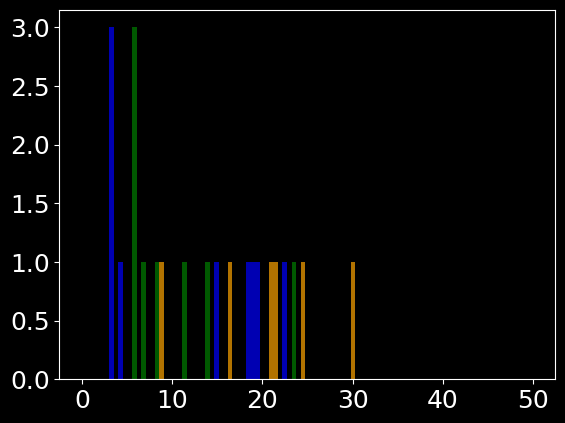

11.966268518150521
20.366056703497275
16.059019288366308


In [4]:
var = "FWI"

fwi_mean = manyfr.groupby(by = ["fireID", "spread_aggrigate_no_igs"], as_index = False)[var].mean()
ig_mean = manyfr.groupby(by = ["fireID", "spread_aggrigate_only_igs"], as_index = False)[var].mean()

bins = np.linspace(0, 50, 100)

plt.rcParams.update({'font.size': 18})
plt.style.use('dark_background')
plt.hist(fwi_mean[fwi_mean.spread_aggrigate_no_igs == False][var], bins, alpha=0.7, label='Stay Day', color = "blue")
plt.hist(fwi_mean[fwi_mean.spread_aggrigate_no_igs == True][var], bins, alpha=0.7, label='Spread Day', color = "orange")
plt.hist(ig_mean[ig_mean.spread_aggrigate_only_igs == True][var], bins, alpha=0.7, label='Ignitions', color = "green")

#plt.legend(loc='upper right')
#plt.tick_params(size = 18)
plt.show()

print(fwi_mean[fwi_mean.spread_aggrigate_no_igs == False][var].mean())
#print(fwi_mean[fwi_mean.spread_aggrigate_no_igs == False][var].std())
print(fwi_mean[fwi_mean.spread_aggrigate_no_igs == True][var].mean())
#print(fwi_mean[fwi_mean.spread_aggrigate_no_igs == True][var].std())
print(ig_mean[ig_mean.spread_aggrigate_only_igs == True][var].mean())
#print(ig_mean[ig_mean.spread_aggrigate_only_igs == True][var].std())


In [15]:
manyfr.st_dist_to_fire.

SyntaxError: can't use starred expression here (197766941.py, line 1)